<a href="https://colab.research.google.com/github/ankit-kothari/Data-Science-Journey/blob/master/custom_model_imdb_deep_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers 
!pip install dask
!pip install 'fsspec>=0.3.3'
!pip install datasets
!pip install torchinfo

In [ ]:
!pip install datasets --upgrade

In [104]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Jul 10 23:07:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    33W / 250W |   8047MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## GPU Setup

In [105]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [106]:
from transformers import pipeline
import torch
import spacy
import tqdm as notebook_tqdm
from torchinfo import summary
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score,roc_auc_score,accuracy_score
from sklearn.metrics import plot_confusion_matrix,classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import  matplotlib.pyplot as plt
from datasets import load_dataset
from spacy.lang.en import English
import warnings
from tqdm import tqdm
import re
import string
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
import concurrent.futures
import dask.bag as db
import dask 
import graphviz
from dask import visualize
from torch import nn 
from transformers import AutoConfig

import tensorflow as tf
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Embedding, LSTM, Bidirectional, GlobalMaxPool1D, Input,BatchNormalization, Dropout, SpatialDropout1D, Conv1D, concatenate
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint


In [107]:
import concurrent.futures
import dask.bag as db
import dask 
import graphviz
from dask import visualize

## Loading the Dataset

In [108]:
from datasets import load_dataset

In [109]:
data = load_dataset('imdb')
del data['unsupervised']

Reusing dataset imdb (/root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1)


  0%|          | 0/3 [00:00<?, ?it/s]

In [110]:
data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
})

In [111]:
data['train']['text'][0]

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, ev

In [112]:
data['train']['label'][1]

0

## Tokenization

In [113]:
from transformers import AutoTokenizer

In [114]:
checkpoint = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [115]:
def tokenize_fn(batch):
  return tokenizer(batch['text'], truncation=True, padding=True) #no padding option since it will be handled by the trainer in thsi case
tokenized_dataset = data.map(tokenize_fn, batched=True)

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

In [116]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
})

In [117]:
text= data['train']['text'][0]

## Keras Tokenizer (Keeping only top 5000 words in the Voccublary)

In [118]:
# convert the sentences (strings) into integers
df_train = data['train']['text']
y_train = data['train']['label']
df_test = data
type(df_train)
MAX_VOCAB_SIZE=5000
tokenizerk = Tokenizer(num_words=5000, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower=True)
## Fitting only on text 
tokenizerk.fit_on_texts(df_train)

In [119]:
word_counts = tokenizerk.word_counts
sorted_word_counts = dict(sorted(word_counts.items(),key=lambda x:x[1], reverse=True))


In [120]:
from collections import defaultdict
top_5000_words = defaultdict()
for key,value in sorted_word_counts.items():
  if len(top_5000_words) > MAX_VOCAB_SIZE-1:
    break
  top_5000_words[key]=value



In [121]:
len(top_5000_words)

5000

In [122]:
def normalize(text,top_5000_words ):
    '''
    Input: list of tokens as strings,  e.g. ['I', ' ', 'saw', ' ', '@psresnik', ' ', 'on', ' ','Twitter']
    Output: list of tokens where
    All tokens are lowercased
    All tokens starting with a whitespace character have been filtered out
    All handles (tokens starting with @) have been filtered out
    Any underscores have been replaced with + (since we use _ as a special character in bigrams)
    '''
    tokenlist = text.split(' ')
    normalized_tokens = [token.lower().replace('!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n','') for token in tokenlist   # lowercase, _ => +
                             if re.search('[^\s]', token) is not None            # ignore whitespace tokens
                             and not token.startswith("@") and token in top_5000_words]
    return " ".join(normalized_tokens)                      # i

In [123]:
text

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, ev

In [124]:
normalize(text,top_5000_words)

"rented from my video store because of all the that surrounded it when it was first released in also heard that at first it was by if it ever tried to enter this therefore being a fan of films considered really had to see this for plot is centered around a young drama student named who wants to learn everything she can about particular she wants to focus her to making some sort of documentary on what the average thought about certain political issues such as the and race issues in the between asking and ordinary of about their opinions on she has sex with her drama and married kills me about is that 40 years this was considered the sex and nudity scenes are few and far even then it's not shot like some made my mind find it in reality sex and nudity are a major in arguably their answer to good old boy had sex scenes in his do the filmmakers for the fact that any sex shown in the film is shown for artistic purposes rather than just to shock people and make money to be shown in theaters i

In [125]:
reviews_list = data['train']['text']
review_bag = db.from_sequence(reviews_list, npartitions=5)
clean_body_train = review_bag.map(normalize,top_5000_words=top_5000_words)


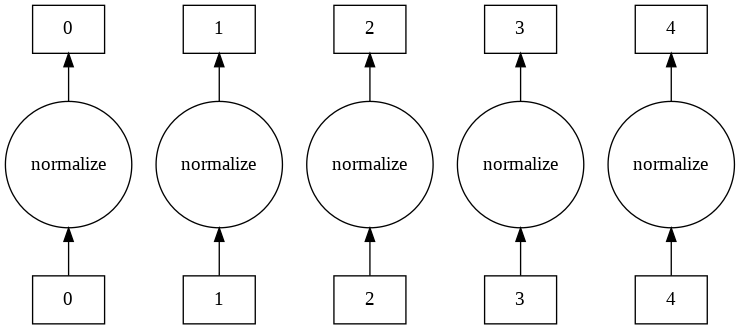

In [126]:
dask.visualize(clean_body_train)

In [127]:
%%time
more_text = clean_body_train.compute()


CPU times: user 636 ms, sys: 606 ms, total: 1.24 s
Wall time: 3.71 s


In [128]:
more_text[0]

"rented from my video store because of all the that surrounded it when it was first released in also heard that at first it was by if it ever tried to enter this therefore being a fan of films considered really had to see this for plot is centered around a young drama student named who wants to learn everything she can about particular she wants to focus her to making some sort of documentary on what the average thought about certain political issues such as the and race issues in the between asking and ordinary of about their opinions on she has sex with her drama and married kills me about is that 40 years this was considered the sex and nudity scenes are few and far even then it's not shot like some made my mind find it in reality sex and nudity are a major in arguably their answer to good old boy had sex scenes in his do the filmmakers for the fact that any sex shown in the film is shown for artistic purposes rather than just to shock people and make money to be shown in theaters i

In [129]:
reviews_list_test = data['test']['text']
review_bag_test = db.from_sequence(reviews_list_test, npartitions=3)
clean_body_test = review_bag_test.map(normalize,top_5000_words=top_5000_words)


In [130]:
more_text_test = clean_body_test.compute()

In [131]:
more_text_test[0]

"love and am willing to put up with a are usually and tried to like really but it is to good as 5 is to cheap cardboard stilted that doesn't match the and painfully characters cannot be overcome with a sure there are those of you out there who think 5 is good clichéd and viewers might like emotion and character is a genre that does not take itself seriously may treat important yet not as a serious really difficult to care about the characters here as they are not simply just missing a of actions and reactions are wooden and often painful to makers of it's rubbish as they have to always say otherwise people would not continue must be turning in their as this poorly edited it without breaks really brings this of a show into kill off a main then bring him back as another all over"

In [132]:
data['train'] = data['train'].add_column(name="cleaned_reviews", column=more_text)
data['test'] = data['test'].add_column(name="cleaned_reviews", column=more_text_test)

In [133]:
data['train']['cleaned_reviews'][0]

"rented from my video store because of all the that surrounded it when it was first released in also heard that at first it was by if it ever tried to enter this therefore being a fan of films considered really had to see this for plot is centered around a young drama student named who wants to learn everything she can about particular she wants to focus her to making some sort of documentary on what the average thought about certain political issues such as the and race issues in the between asking and ordinary of about their opinions on she has sex with her drama and married kills me about is that 40 years this was considered the sex and nudity scenes are few and far even then it's not shot like some made my mind find it in reality sex and nudity are a major in arguably their answer to good old boy had sex scenes in his do the filmmakers for the fact that any sex shown in the film is shown for artistic purposes rather than just to shock people and make money to be shown in theaters i

In [134]:
data['test']['cleaned_reviews'][0]

"love and am willing to put up with a are usually and tried to like really but it is to good as 5 is to cheap cardboard stilted that doesn't match the and painfully characters cannot be overcome with a sure there are those of you out there who think 5 is good clichéd and viewers might like emotion and character is a genre that does not take itself seriously may treat important yet not as a serious really difficult to care about the characters here as they are not simply just missing a of actions and reactions are wooden and often painful to makers of it's rubbish as they have to always say otherwise people would not continue must be turning in their as this poorly edited it without breaks really brings this of a show into kill off a main then bring him back as another all over"

In [135]:
data

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'cleaned_reviews'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'cleaned_reviews'],
        num_rows: 25000
    })
})

## Tokenizing

In [136]:
from transformers import AutoTokenizer

In [137]:
checkpoint = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [138]:
def tokenize_fn(batch):
  return tokenizer(batch['cleaned_reviews'], truncation=True,padding=True) #no padding option since it will be handled by the trainer in thsi case
tokenized_dataset = data.map(tokenize_fn, batched=True)

  0%|          | 0/25 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

In [139]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'cleaned_reviews', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'cleaned_reviews', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
})

##  DistilBERT Config File

In [140]:
import torch.nn as nn
from transformers import DistilBertConfig
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers.models.distilbert.modeling_distilbert import DistilBertModel
from transformers.models.distilbert.modeling_distilbert import DistilBertPreTrainedModel


In [141]:
tags = data["train"].features["label"]
print(tags)

ClassLabel(num_classes=2, names=['neg', 'pos'], id=None)


In [142]:
target_map = {'negative': 0,  'positive': 1}
index2tag = {v:k for k,v in target_map.items()}
tag2id = target_map

In [143]:
distilbert_config = AutoConfig.from_pretrained(checkpoint, 
                                            num_labels=tags.num_classes,
                                            id2label = index2tag,
                                            label2id = tag2id)

In [144]:
distilbert_config

DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "negative",
    "1": "positive"
  },
  "initializer_range": 0.02,
  "label2id": {
    "negative": 0,
    "positive": 1
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.20.1",
  "vocab_size": 30522
}

## Custom Model 

In [145]:
class IMDBModel(DistilBertPreTrainedModel):
    config_class = DistilBertConfig # The config class associated to this model architecture (DistilBertConfig) 
    def __init__(self, config):
        super().__init__(config)
        self.num_labels = config.num_labels
        # DistilBertForSequenceClassification is a sub-class of DistilBertModel
        self.distilbert = DistilBertModel(config) 
        # dropout is a layer in the DistilBertForSequenceClassification
        self.dropout = nn.Dropout(config.dropout) 
        # linear layer to map the output of the DistilBertForSequenceClassification to the number of labels
        self.classifier = nn.Linear(config.dim, config.num_labels)
        self.init_weights() # initialize the weights of the model

   
    def forward(self, input_ids=None, attention_mask=None, labels=None):
        # call the DistilBertForSequenceClassification
        outputs = self.distilbert(input_ids, attention_mask=attention_mask) 
        # last_hidden_state is a tensor of shape (batch_size, sequence_length, hidden_size)
        last_hidden_layer = outputs.last_hidden_state[:,0,:] #embedding of the [CLS Token] 
        # dropout the last_hidden_layer
        seq_outputs = self.dropout(last_hidden_layer)
        # call the linear layer to map the output of the DistilBertForSequenceClassification to the number of labels (2 in this case) and return the logits of the model (the output of the linear layer) as a tensor of shape (batch_size, sequence_length, num_labels)
        logits = self.classifier(seq_outputs)

        if labels is not None:
            # call the cross entropy loss function to compute the loss and return the loss value as a tensor of shape (batch_size, 1)
            # logits.view(-1, self.num_labels) has a shape [batch_size, num_labels] and labels.view(-1) has shape [batch_size] tensors
            loss = nn.CrossEntropyLoss()(logits.view(-1, self.num_labels), labels.view(-1))
      
        return SequenceClassifierOutput(logits=logits, loss=loss, hidden_states=outputs.hidden_states, attentions=outputs.attentions)

In [146]:
##tokenized data 
sample_text = data['train']['cleaned_reviews'][0]
smaple = tokenizer(sample_text, truncation=True,padding="max_length", return_tensors='pt',max_length=512)
smaple.keys()

dict_keys(['input_ids', 'attention_mask'])

#### Running Model through a sample

In [147]:
model_distilbert = (IMDBModel.from_pretrained("distilbert-base-uncased",config=distilbert_config).to(device))

In [148]:
#model_distilbert

In [149]:
sample_label = data['train']['label'][0]
type(sample_label)
sample_label = torch.tensor(sample_label, dtype=torch.long)
type(sample_label)

torch.Tensor

In [150]:
preds_distilebert= model_distilbert(sample.to(device),labels=sample_label.to(device))
preds_distilebert

SequenceClassifierOutput([('loss',
                           tensor(0.6636, device='cuda:0', grad_fn=<NllLossBackward0>)),
                          ('logits',
                           tensor([[-0.0262, -0.0862]], device='cuda:0', grad_fn=<AddmmBackward0>))])

In [151]:
preds_distilebert.loss.cpu().detach().numpy()

array(0.66361594, dtype=float32)

In [152]:
preds_distilebert.logits.argmax(-1)

tensor([0], device='cuda:0')

## Training Arguments

In [153]:
from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification
## Training Arguments
batch_size= 16
logging_steps = len(tokenized_dataset["train"]) // batch_size
model_name = "imdb_data_custom_model"
training_args = TrainingArguments(
    output_dir = model_name,
    evaluation_strategy='epoch', # evaluate the model every epoch
    num_train_epochs=2, # train for 2 epochs
    learning_rate=2e-5, # learning rate for AdamW
    per_device_train_batch_size=batch_size, # batch size for training
    per_device_eval_batch_size=batch_size, # batch size for evaluation
    save_strategy='epoch', # save the model every epoch
    logging_steps=logging_steps, # log every epoch
    log_level="error",  # log level
    push_to_hub=False,
    disable_tqdm=False
    )

## Custom Metric Function

In [154]:
def compute_metrics(pred):
  labels=pred.label_ids # get the labels 
  preds = pred.predictions.argmax(-1) # get the index of the max logit
  f1 = f1_score(labels,preds, average="weighted")
  acc = accuracy_score(labels,preds)
  return {"accuracy":acc,"f1":f1 }

## Training

In [155]:
from transformers import Trainer 
trainer = Trainer(model=model_distilbert, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=tokenized_dataset['train'],
                  eval_dataset = tokenized_dataset['test'],
                  tokenizer=tokenizer)

In [156]:
from transformers import Trainer 
trainer = Trainer(model=model_distilbert, # the model to train
                  args=training_args, # the training arguments
                  #the input to the compute_metrics function is  the predictions from the model and the labels from the dataset and the output is a dictionary of metrics to be used for evaluation and logging
                  compute_metrics=compute_metrics, 
                  train_dataset=tokenized_dataset['train'], # the training dataset
                  eval_dataset = tokenized_dataset['test'], # the evaluation dataset
                  tokenizer=tokenizer) # the tokenizer

In [157]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.325700,0.259585,0.893400,0.893307
2,0.200000,0.268881,0.900920,0.900900


TrainOutput(global_step=3126, training_loss=0.2629525894853295, metrics={'train_runtime': 1793.4586, 'train_samples_per_second': 27.879, 'train_steps_per_second': 1.743, 'total_flos': 6532655001600000.0, 'train_loss': 0.2629525894853295, 'epoch': 2.0})

In [158]:
trainer.evaluate()

{'epoch': 2.0,
 'eval_accuracy': 0.90092,
 'eval_f1': 0.9008997916440724,
 'eval_loss': 0.2688814401626587,
 'eval_runtime': 224.5196,
 'eval_samples_per_second': 111.349,
 'eval_steps_per_second': 6.962}

## Saving the model 

In [159]:
!ls -ltra airline_tweet_lp_real

ls: cannot access 'airline_tweet_lp_real': No such file or directory


In [160]:
from transformers import pipeline
#loading the trained model with a specific checkpoint
imdb_model = pipeline('text-classification',
                      model=f"{model_name}/checkpoint-3126",
                      device=0)

In [161]:
imdb_model(data['test']['cleaned_reviews'][0])

[{'label': 'positive', 'score': 0.5062223672866821}]

## Error Analysis

In [162]:
f"{model_name}/checkpoint-3126"

'imdb_data_custom_model/checkpoint-3126'

In [163]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

In [164]:
from torch.nn.functional import cross_entropy
def forward_pass_with_custom_model(batch):
    #place all input tensors on the device 
    inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    #call the model
    with torch.no_grad():
        outputs = model_distilbert(input_ids=inputs["input_ids"].to(device) , attention_mask=inputs["attention_mask"].to(device), labels=batch["label"].to(device))
        #get the logits
        logits = outputs.logits
        pred_labels = logits.argmax(-1)
        loss = cross_entropy(logits, batch["label"].to(device), reduction="none") #shape of logits is (batch_size, num_labels) and shape of batch["label"] is (batch_size)
        #place the outputs on the CPU for compatibility with the other dataset columns  
        return {"pred_labels": pred_labels.cpu().numpy(),"batch_loss": loss.cpu().numpy() }

In [165]:
#convert dataset to pytocrch tensors
tokenized_dataset.set_format("torch", columns=["input_ids","attention_mask" ,"label"])
#Compute loss values
tokenized_dataset["test"] = tokenized_dataset["test"].map(forward_pass_with_custom_model, batched=True, batch_size=16)

Loading cached processed dataset at /root/.cache/huggingface/datasets/imdb/plain_text/1.0.0/2fdd8b9bcadd6e7055e742a706876ba43f19faee861df134affd7a3f60fc38a1/cache-1c80317fa3b1799d.arrow


In [166]:
index2tag

{0: 'negative', 1: 'positive'}

#### Added the predicted label and loss columns

In [167]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'cleaned_reviews', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label', 'cleaned_reviews', 'input_ids', 'attention_mask', 'pred_labels', 'batch_loss'],
        num_rows: 25000
    })
})

In [168]:
tokenized_dataset.set_format("pandas")
cols = ["text","label","pred_labels","batch_loss","cleaned_reviews"]
df_test= tokenized_dataset["test"][:][cols]
df_test['label'] = df_test["label"].map(index2tag)
df_test['pred_labels']=df_test['pred_labels'].map(index2tag)


In [169]:
df_test.head(1)

,text,label,pred_labels,batch_loss,cleaned_reviews
0,"I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star Trek (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that doesn't match the background, and painfully one-dimensional characters cannot be overcome with a 'sci-fi' setting. (I'm sure there are those of you out there who think Babylon 5 is good sci-fi TV. It's not. It's clichéd and uninspiring.) While US viewers might like emotion and character development, sci-fi is a genre that does not take itself seriously (cf. Star Trek). It may treat important issues, yet not as a serious philosophy. It's really difficult to care about the characters here as they are not simply foolish, just missing a spark of life. Their actions and reactions are wooden and predictable, often painful to watch. The makers of Earth KNOW it's rubbish as they have to always say ""Gene Roddenberry's Earth..."" otherwise people would not continue watching. Roddenberry's ashes must be turning in their orbit as this dull, cheap, poorly edited (watching it without advert breaks really brings this home) trudging Trabant of a show lumbers into space. Spoiler. So, kill off a main character. And then bring him back as another actor. Jeeez! Dallas all over again.",negative,negative,0.003289,love and am willing to put up with a are usually and tried to like really but it is to good as 5 is to cheap cardboard stilted that doesn't match the and painfully characters cannot be overcome with a sure there are those of you out there who think 5 is good clichéd and viewers might like emotion and character is a genre that does not take itself seriously may treat important yet not as a serious really difficult to care about the characters here as they are not simply just missing a of actions and reactions are wooden and often painful to makers of it's rubbish as they have to always say otherwise people would not continue must be turning in their as this poorly edited it without breaks really brings this of a show into kill off a main then bring him back as another all over


#### Rows with the Maximum Loss

In [170]:
df_test.sort_values("batch_loss",ascending=False).head(2)

,text,label,pred_labels,batch_loss,cleaned_reviews
9543,"Lois Weber's film ""Hypocrites"" was and still kind of is a very bold and daring film. I enjoyed it and was very impressed by the filming and story of it. The priest sees the hypocrisy of the people in his church and tries to show them the ""naked"" truth. The people are appalled when he reveals the naked statue portraying truth, after failing to lead them to it and the few that did, help along the way. The people do not want to face the truth that they are doing anything wrong, but it shows them putting things before God, going to beach parties acting inappropriate, their materialistic ways, and other things in which the people of our world do that tend to not be morally right. In the end, failing to gain any followers, he must enter into the gates of heaven alone. This film seems to me to be very bold, in the fact that a naked woman is shown throughout it, especially considering the time period in which this film was made. The imagery and symbolism portrayed in this movie I found incredible. The way they made the naked woman translucent and using a naked woman to symbolize the naked truth shows a lot of creativity and art. Showing the different sins of the people as they walked down the road and refused to follow along the path, each with different excuses, setbacks, and/or higher priorities, was a great way of representing the people of today. This film does a very good job of getting the moral message across to its audience. Lois Weber has a tremendous way of capturing her spectators' attention with her creativity, symbolism, visuals, and through auditory. Even the music of the piano throughout this film is very beautiful and fitting with the whole theme.",negative,positive,6.282280,film was and still kind of is a very bold and daring enjoyed it and was very impressed by the filming and story of priest sees the of the people in his church and tries to show them the people are when he reveals the naked portraying after failing to lead them to it and the few that help along the people do not want to face the truth that they are doing anything but it shows them putting things before going to beach parties acting their and other things in which the people of our world do that tend to not be the failing to gain any he must enter into the of heaven film seems to me to be very in the fact that a naked woman is shown throughout especially considering the time period in which this film was imagery and symbolism portrayed in this movie found way they made the naked woman and using a naked woman to the naked truth shows a lot of creativity and the different of the people as they walked down the road and to follow along the each with different higher was a great way of the people of film does a very good job of getting the moral message across to its has a tremendous way of capturing her attention with her and through the music of the piano throughout this film is very beautiful and fitting with the whole
19488,"The lovely, yet lethal Alexandra (stunning statuesque blonde beauty Stacie Randall, who looks absolutely smashing in a tight black leather outfit) must find a magic amulet so her evil demonic master Faust can cross over into our dimension. It's up to fearless, rugged cop Jonathan Graves (likable Peter Liapis) to stop her. Meanwhile, two pitifully unfunny ""comic relief"" dwarf gnome creatures run amok in Los Angeles. Seasoned veteran schlock exploitation expert Jim Wynorski relates the supremely inane story at a brisk pace and takes none of this foolishness remotely seriously. The cast struggle gamely with the silly material: the adorable Barbara Alyn Woods as sassy, fetching police captain Kate, Raquel Krelle as tart, sexy hooker Jeanine, Bobby Di Cicco as Graves' bumbling, excitable partner Scotty, Peggy Trentini as alluring museum curator Monica, and Ace Mask as the jolly Dr. Rochelle. Mark Stevi's puerile cookie cutter script, an amusingly lowbrow sense of no-brainer

#### Rows with Minimum Loss

In [171]:
df_test.sort_values("batch_loss",ascending=True).head(2)

,text,label,pred_labels,batch_loss,cleaned_reviews
24354,"The Cure is an outstanding real-life drama that deals with a very sensitive subject. It is the story of the profound and dear friendship between two boys, Eric and Dexter. The latter has acquired AIDS from a blood transfusion. Thus he and his mom (Annabella Sciorra) have become outcasts, shunned by the public and labeled as dangerous company, basically due to a common lack of public knowledge of the disease.<br /><br />When Eric (Brad Renfro, known from 'The Client' and 'Apt Pupil') and his mom move into the house next to them, he has to deal with public insults and the fear of catching AIDS himself. However, Eric overcomes his fear and risks everything. At first he starts talking to Dexter, but eventually he climbs over the fence and joins the witty boy (played by Jurassic Park's Joseph Mazzello) and his games. Very quickly he develops a real friendship with Dexter, who is delicately built and frail due to his condition.<br /><br />The central theme of the movie  the theme which makes it pervasively authentic and tragic at the same time  is how Eric and Dexter try to find the ultimate cure. At first they experiment with all kinds of plants and leaves  which is very naive, but also genuine at the same time, as it shows how young kids deal with such heinous diseases and how strongly they still believe in the magic of the world. When they hear about an alleged cure which has been developed in the South, they do not hesitate and take off for an adventure that will bring them even closer together and symbolizes the ultimate quest for hope.<br /><br />So they board a raft and head southwards on the Mississippi River. What starts as a real adventure becomes a dangerous undertaking, which is emotionally intriguing and instructive at the same time. The scene when Dexter reveals his fears and talks about the end of the universe, where everything is dark and cold, Eric hands him his sneaker, a symbol that wherever the boy may have to go, Eric is and will always be with him; he will never have to be alone. This sequence, which is one of the most compelling ones of the movie, features a very convincing interaction between the two actors, who manage to avoid awkward and corny dialogs and deliver a very genuine performance that is eventually smashing in its tenderness and honesty.<br /><br />I will not go any further in outlining the plot, as I do not intend to give away too much information. The ending however is emotionally tough and makes the audience so much a part of the tragedy that everyone who watches the movie will feel personally affected. This aspect makes this movie so strong, so outstanding and so convincing. The emotional burden on every character is so real and so thrashing that even the tougher members of the audience might need some hankies.<br /><br />A 10 is doing justice to this movie and is not too high a rating. There is hardly any other movie I have seen in my life so far that handles such an emotional issue with so much wit and sensibility. It is the story of how two boys make each other's life richer and how they teach each other lessons of life. Thus Dexter overcomes his isolation and sadness, and Eric learns what really counts in life; and both of them realize how much of a gift real friendship is when it comes to the hardest moments of life.<br /><br />This movie is tragic  but its message is sheer inspiration.",positive,positive,0.001177,is an outstanding drama that deals with a very sensitive is the story of the profound and dear friendship between two and latter has from a blood he and his mom have become by the public and as dangerous basically due to a common lack of public knowledge of the known from and and his mom move into the house next to he has to deal with public and the fear of catching his fear and first he starts talking to but eventually he over the and the witty boy by and his quickly he develops a real friendship with who is built an